In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants
    
from time import time
import logging
from urllib.parse import quote
import shutil
from pathlib import Path
import re
import json
from os import path
import json


import requests
from dictor import dictor
from datetime import datetime
import pytz

    


In [3]:
def get_coord(*args, print_response=True, **kwargs):
    '''USER FACING HELPER FUNCTION:
    lookup and my_print the latitude, longitude of a place given as a string:
    
    usage: --run_plugin_func moon_phase.get_coord "Cotu, Provence, Country"
    
    --run_plugin_func moon_phase.get_coord "Morrison, Colorado, USA"
    >>> Morrison, Jefferson County, Colorado, 80465, United States
    Morrison, Colorado, USA:
    lat: 39.642
    lon: -105.193
    ('39.6422', '-105.19332324506902')
    
    Args:
        place(`str`): "City, Provence, Country
    
    Returns:
        `tuple`: lat, lon
        
    Example:
        get_coord("Denver, Colorado, USA")
        get_coord("Bamako, Mali")
        %U'''
    def my_print(args):
        if print_response:
            print(args)
        else:
            pass
    if args:
        place = args[0]
    elif 'place' in kwargs:
        place = kwargs['place']
    else:
        place = None
    
    
    
    lat, lon = None, None
    if not place:
        my_print('lookup the lat/lon of city, town or geographic area')
        my_print('usage: moon_phase.get_coord "City, Area, Country"')
        my_print('moon_phase.get_coord "Golden Colorado, USA"')
        my_print("""\nGolden, Jefferson County, Colorado, 80401, United States
Golden Colorado, USA:
lat: 39.756
lon: -105.221
('39.755543', '-105.221099')""")
        return (lat, lon)
    
    osm_endpoint = constants.osm_endpoint
    osm_query = constants.osm_query
    place_quote = quote(place)
    url = f'{osm_endpoint}{place_quote}{osm_query}'
    try:
        result = requests.get(url)
    except requests.RequestException as e:
        logging.warning(f'could not process request: {e}')
    if result.status_code == 200:
        if len(result.json()) > 0:
            lat = dictor(result.json()[0], 'lat')
            lon = dictor(result.json()[0], 'lon')
            display_name = dictor(result.json()[0], 'display_name')
            my_print(f'{display_name}\n{place}:\nlat: {float(lat):.3f}\nlon: {float(lon):.3f}')
        else:
            my_print(f'no data was returned for place: {place}')
            my_print(f'check the spelling or try a more general query')
    else:
        my_print(f'No valid data was returned: status_code: {result.status_code}')
    
    return(lat, lon)    

In [4]:
def list_country_locales(country=None):
    '''USER FACING HELPER FUNCTION:
    Print the known timezones for a country specified 
    with two letter country code:
    
    usage: 
    --run_plugin_func moon_phase.list_country_locales <ISO 3166 Country Code>
    
    --run_plugin_func moon_phase.list_country_locales NZ
    >>> ['Pacific/Auckland', 'Pacific/Chatham']
    
    Args:
        country(`str`): two letter ISO 3166 country code
    
    %U'''
    if not country:
        print('No country code provided.')
        print('Specify one of the known ISO 3116 country codes:')
        cc = [i for i in pytz.country_names]
        _col_print(cc, term_width=60)
    
    else:
        try:
            print(pytz.country_timezones[country])
        except KeyError as e:
            print('Unknown country code. Try again with no country code to see a full list')
    


In [5]:
def _get_offset(timezone):
    '''return an offset of a pytz timezone in Region/Locale as +/-HH:MM format
    
    use function list_country_offsets() to find the known Region/Locales 
        
    Example: _get_offset("Pacific/Fiji")
    >>> +13:00
        
    Args: 
        timezone(`str`): Region/Locale 
        
    Returns:
        `str` +/- HH:MM format '''
    offset = datetime.now(pytz.timezone(timezone)).strftime('%z')
    offset_hhmm = f'{offset[0:3]}:{offset[3:]}'
    return offset_hhmm

In [6]:
def _col_print(lines, term_width=None, indent=0, pad=2):
    '''print list in columns dependent on the term_width value
    
    Args:
        lines(`list`): one dimensional list
        term_width(`int`): width of terminal in columns
        indent(`int`): characters to indent
        pad(`int`): padding between columns
        
    https://gist.github.com/critiqjo/2ca84db26daaeb1715e1'''
    
    if not term_width:
        size = shutil.get_terminal_size((80, 20))
        term_width = size.columns
    n_lines = len(lines)
    if n_lines == 0:
        return

    col_width = max(len(line) for line in lines)
    n_cols = int((term_width + pad - indent)/(col_width + pad))
    n_cols = min(n_lines, max(1, n_cols))

    col_len = int(n_lines/n_cols) + (0 if n_lines % n_cols == 0 else 1)
    if (n_cols - 1) * col_len >= n_lines:
        n_cols -= 1

    cols = [lines[i*col_len : i*col_len + col_len] for i in range(n_cols)]

    rows = list(zip(*cols))
    rows_missed = zip(*[col[len(rows):] for col in cols[:-1]])
    rows.extend(rows_missed)

    for row in rows:
        print(" "*indent + (" "*pad).join(line.ljust(col_width) for line in row))

In [7]:
def _tryconvert(value, default, *types):
    '''try to convert a given value to a member of `types` or return a default value
    
    Args:
        value: value to convert
        default: value to return if all else fails
        types: list of types to attempt to convert value to
        
    Returns:
        `valu`e converted to a member of `types` or `default`'''
    
    for t in types:
        try:
            return t(value)
        except (ValueError, TypeError):
            continue
    return default

In [8]:
def _get_value(my_data, key, address, default=None):
    '''get data from JSON dictionary and handle errors gracefully

    Args:
        json_data(`dict`): json formatted dictionary
        key(`str`): key to retrieve from address
        address(`str`): dotted address and index to find in dictionary e.g. foo.bar[0]
        default: value to return if address/key are not found'''
    success = True
    value = None

    try:
        my_dict = dictor(my_data, address)
        value = my_dict[key]
    except KeyError as e:
        logging.error(f'KeyError: {address}.{e} not found in API data')
        success = False
    except TypeError as e:
        logging.error(f'TypeError processing JSON data: {e}')
        success = False

    if default and not success:
        logging.warning(f'failed to set data, returning default value: {default}')
        value = default            

    return value

In [9]:
def _process_data(json_data, timezone=constants.required_config_options['location_name']):
    
    '''process JSON data into data dictionary for the Plugin'''
    
    
    logging.debug(f'JSON Data: {json_data}')
    logging.debug(f'timezone: {timezone}')
    
    # return value defaults
    failure = False
    data = {
        'Moonrise': '00:00',
        'moonset': '00:00',
        'Image_file': constants.error_image,
        'phase_desc': 'Error: Check Logs'
    }
    
    # set default values for rise/set time
    rise_set = {
                    'moonrise': {
                        'iso_str': '1970-01-01T00:00+00:00',
                        'time': ''
                    },
                    'moonset': {
                        'iso_str': '1970-01-01T00:00+00:00',
                        'time': ''
                    }
                }
    
    moon_images = {file.stem: file for file in Path(constants.image_path).glob('*.jpeg')}
    
    # time conversion manipulation
    
    # set local timezone based on timezone name
    try:
        local_tz = pytz.timezone(timezone)
    except pytz.exceptions.UnknownTimeZoneError as e:
        logging.warning(f"unusable timezone: '{timezone}'; falling back to: {constants.required_config_options['location_name']}")
        local_tz = pytz.timezone(constants.required_config_options['location_name'])
        
    logging.debug(f'local_tz: {local_tz}')
    
    # extract the rise/set time from the json data
    rise_set['moonrise']['iso_str'] = _get_value(json_data, 'time', 'properties.moonrise', constants.fallback_time)
    rise_set['moonset']['iso_str'] = _get_value(json_data, 'time', 'properties.moonset', constants.fallback_time)
    
    
    # convert the times into local time strings for display
    for i in rise_set:
        iso_str = rise_set[i]['iso_str']
        # create a datetime object
        try:
            dt = datetime.fromisoformat(iso_str)
        except (ValueError, TypeError) as e:
            logging.warning(f'error setting date time: {e}')
            dt = datetime.fromisoformat(constants.fallback_time)
            failure = True
        
        try:
            local_dt = dt.astimezone(local_tz)
        except (TypeError, ValueError) as e:
            logging.warning(f"could not set local dt due to errors: {e}; falling back to best guess")
            local_dt = dt.astimezone()
            failure = True
        
        try:
            time = local_dt.strftime("%H:%M")
        except Exception as e:
            logging.warning(f'error setting local time string: {e}')
            logging.warning(f'falling back to "ER: See Log"')
            failure = True
        
        rise_set[i]['time'] = time
    
    logging.debug(f'moonrise/moonset: {rise_set}')
    
    # get the appropriate image file and description
    phase = _get_value(json_data, 'moonphase', 'properties', None)
    
    phase = _tryconvert(phase, 1000., float)
        
    logging.debug(f'JSON phase value: {phase}')
        
    if  phase < 0. or phase > 360.:
        logging.warning(f'bad phase data in JSON: {phase}')
        failure = True
        moon_image = constants.error_image
        phase_desc = 'Error: Check Logs'
    else:
        # use the lambda function to find the closest value in the filenames
        moon_img_key = min(moon_images.keys(), key=lambda x:
                           abs(_tryconvert(x, 0, float) - _tryconvert(phase, 0, float)))
        moon_image = moon_images[moon_img_key]
        
        # use the lambda function to find the closest value in the constants descriptions 
        phase_desc_key = min(constants.phase_desc.keys(), key=lambda x:
                             abs(x - _tryconvert(phase, 0, float)))
        
        phase_desc = constants.phase_desc[phase_desc_key]
        
    logging.debug(f'moon_image: {moon_image}')
    logging.debug(f'phase_desc: {phase_desc}')
    
    # set the data to be returned 
    data['moonrise'] = f"Moonrise: {rise_set['moonrise']['time']}"
    data['moonset'] = f"Moonset: {rise_set['moonset']['time']}"
    data['image_file'] = moon_image
    data['phase_desc']= phase_desc
    
    if failure:
        data['image_file'] = constants.error_image
    
    
    return data

In [10]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function for moon_phase plugin provides an image of the moon and moon data for a location
    
    This plugin provides the following information:
    
     * Accurate image of the moon at moon rise
     * Moon Rise time at location
     
    
    Configuration Requirements:
        self.config(dict): {
            'location_name': 'Europe/Amsterdam', 
            'email': Your_Email@some.domain,
            'lat': xx.yy,     # this is optional, but will provide more accuracy
            'lon': -ss.qq,    # this is optional, but will provide more accuracy
        }
        
    Args: 
        self.cache(`CacheFiles` object)
        
    Args:
        self(namespace): namespace from plugin object
    
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))
        
    
    Images are sourced from of NASA's Scientific Visualization sutudio: https://svs.gsfc.nasa.gov/4955#32006
    and represent the first full lunar month of 2022.
    
    Moonrise data is sourced from the Meteorologisk Institutt of Norway: 
    https://api.met.no/weatherapi/sunrise/2.0/documentation#!/data/get
            
    %U'''   
    
    is_updated = False
    data = constants.default_data
    priority = self.max_priority
    
    failure = (is_updated, data, priority)
    
    json_file = self.cache.path/constants.json_file
    json_data = None
    
    
    # check the passed in configuration
    if hasattr(self, 'configured'):
        pass
    else:
        # if add any missing configuration keys
        for k, v in constants.required_config_options.items():
            if not k in self.config:
                logging.debug(f'missing config value: {k}')
                logging.debug(f'using config value: {v}')
                self.config[k] = v
        if self.config['email']:
            self.config['user_agent'] = f'{constants.name}, v{constants.version} -- {self.config["email"]}'
        else:
            logging.warning('missing email address in configuration file -- cannot create user agent string')
            self.config['user_agent'] = None
            
        # set lat/lon based on the region/locale data 
        if not (self.config['lat'] and self.config['lon']):
            logging.info(f'no lat/lon provided, guessing based on {self.config["location_name"]}')
            self.config['lat'], self.config['lon'] = get_coord(self.config['location_name'], print_response=False)
        
        # set the UTC offset based on the location name
        try:
            self.config['offset'] = _get_offset(self.config['location_name'])
        except UnknownTimeZoneError as e:
            logging.error(f'unknown location: {self.config["location_name"]}')
            logging.error(f'using default location: {constants.required_config_options["location_name"]}')
            
        self.configured = True
        

    # build a request see: https://api.met.no/weatherapi/sunrise/3.0/documentation#!/data/get_moon
    # header format: https://api.met.no/doc/FAQ
    if self.config['user_agent']:
        user_agent = self.config['user_agent']
        logging.debug(f'user_agent string: {user_agent}')
    else:
        logging.warning('no user-agent string available -- cannot complete request')
        return failure
        
    headers = {'User-Agent': user_agent, 
              'From': self.config['email']}
    
    param = {
        'lat': self.config['lat'],
        'lon': self.config['lon'],
#         'date': datetime.now().strftime('%Y-%m-%d'),
        'offset': self.config['offset']}
        
    # get the mtime of the cached json file
    logging.debug(f'checking mtime of cached json file: {json_file}')
    try:
        mtime  = time() - path.getmtime(json_file)
        logging.debug(f'age of {json_file}: {mtime}')
    except OSError as e:
        logging.info(f'{e}')
        mtime = 2**16
    except json.JSONDecodeError as e:
        logging.info(f'{e}')
        mtime = 2**16
        
    
    # if a recent, readable json data file exists, use the cached data
    if json_file.exists() and mtime < constants.json_max_age:
        try:
            logging.debug('using cached met.no data')
            with open(json_file) as jf:
                json_data = json.load(jf)
        except OSError as e:
            logging.warning(f'could not open cached JSON file: {e}')
        except json.JSONDecodeError as e:
            logging.error(f'could not decode JSON file: {e}')
            json_data = None
    else:
        json_data = None
            
    
    # if the json data is not available from the cache, request
    if not json_data:
        # make the request
        try:
            logging.debug('downloading fresh data from met.no API')
            moonrise = requests.get(constants.met_endpoint, param, headers=headers)
        except requests.RequestException as e:
            logging.warning(f'failed to download JSON data: {e}')
            return failure
            
        # check there is valid data
        if moonrise.status_code in [200]:
            try:
                with open(json_file, 'w')  as jf:
                    json.dump(moonrise.json(), jf)
            except OSError as e:
                logging.warning(f'failed to cache {json_file}: {e}')
            json_data = moonrise.json()
        else: 
            logging.warning(f'api error with status_code: {moonrise.status_code}')
            json_data = None
                    
    if json_data:
        data = _process_data(json_data)
        is_updated = True
        priority = self.max_priority
        
    else:
        logging.warning('all attempts to fetch API data has failed. No result.')
        return failure
    
    return (is_updated, data, priority)



DEBUG:root:[[----checking default values for layout----]
DEBUG:root:section: [-----------moonrise-----------]
DEBUG:root:adding "max_lines: 1"
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:section: [-----------moonset------------]
DEBUG:root:adding "max_lines: 1"
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:section: [----------image_file----------]
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:section: [----------phase_desc----------]
DEBUG:root:adding "max_lines: 1"
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:[[....calculating layouts....]]
INFO:root:section: [...........moonrise...........]
DEBUG:root:resolution: (800, 600)
DEBUG:root:width: 0.5

DEBUG:PIL.TiffImagePlugin:tag: PhotometricInterpretation (262) - type: short (3) - value: b'\x00\x02'
DEBUG:PIL.TiffImagePlugin:tag: Orientation (274) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: WhitePoint (318) - type: rational (5) Tag Location: 46 - Data Location: 74 - value: b'\x00\x00%\xca\x00\x00x\xd9'
DEBUG:PIL.TiffImagePlugin:tag: PrimaryChromaticities (319) - type: rational (5) Tag Location: 58 - Data Location: 90 - value: b'\x00\x00\x00\x10\x00\x00\x00\x19'
DEBUG:PIL.TiffImagePlugin:tag: ExifIFD (34665) - type: long (4) - value: b'\x00\x00\x00\x8a'
DEBUG:root:image dimensions: (1080, 1080)
DEBUG:root:idx:0 diemension (1080) is greater than idx:0 padded_area: 800
DEBUG:root:idx:1 diemension (1080) is greater than idx:1 padded_area: 504
DEBUG:root:resizing image to: [800, 504]
DEBUG:root:padding: 0
DEBUG:root:h centering: x=148
DEBUG:root:v centering: y=0
DEBUG:root:pasting image at: 148, 0


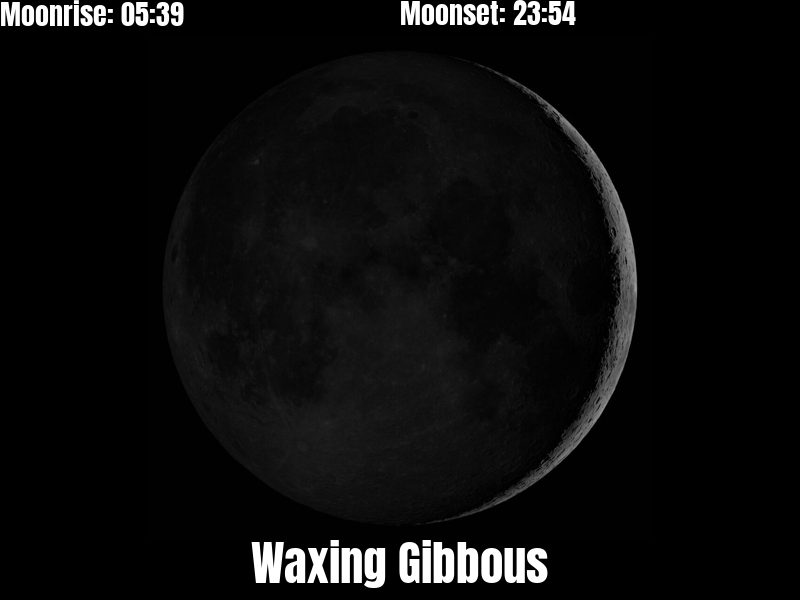

In [15]:
# # this code snip simulates running from within the display loop use this and the following
# # cell to test the output
# # fugly hack for making the library module available to the plugins
# import sys
# sys.path.append(layout.dir_path+'/../..')
# from library import PluginTools
# import logging
# logging.root.setLevel('DEBUG')
# from library.CacheFiles import CacheFiles
# from library.Plugin import Plugin
# from IPython.display import display
# test_plugin = Plugin(resolution=(800, 600), screen_mode='RGB')
# test_plugin.config = {
#     'text_color': 'random',
#     'bkground_color': 'White',
#     'location_name': 'Europe/Amsterdam',
#     'email': 'aaron.ciuffo@gmail.com',
#     'lat': 52.3,
#     'lon': 4.9

# }
# test_plugin.refresh_rate = 5
# l = layout.layout
# test_plugin.layout = l
# test_plugin.cache = CacheFiles()
# test_plugin.update_function = update_function
# test_plugin.update()
# test_plugin.image

In [12]:
# test_plugin.update_function = update_function
# test_plugin.update()
# test_plugin.image

In [16]:
!jupyter-nbconvert --to python --template python_clean moon_phase.ipynb

[NbConvertApp] Converting notebook moon_phase.ipynb to python
[NbConvertApp] Writing 18047 bytes to moon_phase.py
